In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd
import json
import configparser
from pathlib import Path
import os

from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import mean_squared_error as MSE
def RMSE(y_real, y_predict):
    return np.sqrt(MSE(y_real, y_predict))
    
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import MaxPooling1D

configs = configparser.ConfigParser()
configs.read("configuracoes.conf",encoding='utf-8')

data_folder = Path(configs["DEFAULT"]["folder_path"])
path = data_folder / configs["DEFAULT"]["file"]
objeto = configs["DEFAULT"]["objeto"]
regiao = configs["DEFAULT"]["regiao"]

In [2]:
look_back = 12 #Quantidade de meses anteriores usado para prever
forecast_horizon = int(configs["DEFAULT"]["meses"]) #Quantidade de meses previstos

model_mape = []
model_rmse = []

for i in range(0,1):

    #Carrega os dados
    cesta = pd.read_excel(path)
    cesta.drop(['ano', 'salario', 'preco'], axis=1, inplace=True)

    #Cria sequencia de dados do tamanho (meses anterioes + meses a serem previstos)
    for n_step in range(1, look_back + forecast_horizon):
        cesta[f'razao t(h + {n_step})'] = cesta['razao'].shift(-n_step).values
    cesta.dropna(inplace=True)
    cesta.reset_index(drop=True, inplace=True)

    #Divide os dados em Treino, Validação e Teste
    X_train = cesta.iloc[:-67:, :look_back:].values
    y_train = cesta.iloc[:-67:, look_back::].values
    X_val = cesta.iloc[-67:-37:, :look_back:].values
    y_val = cesta.iloc[-67:-37:, look_back::].values
    y_val2 = cesta.iloc[-67:-37:, look_back::].values.tolist()

    #remodela os dados para formato (batchs, months, features)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))

    #Cria o modelo
    model=Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, input_shape=(look_back,1), activation='tanh'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(25, activation='tanh'))
    model.add(Dense(forecast_horizon))
    model.compile(loss='mean_squared_error', optimizer='adam')

    #Treina e pever (forecast_horizon) quantidade de tempo
    history = model.fit(X_train, y_train, epochs= 150,  batch_size=1, shuffle=False, validation_data=(X_val, y_val))
    forecast = model.predict(X_val)

"""
    model_rmse.append(RMSE(y_val2, forecast))
    model_mape.append(MAPE(y_val2, forecast) * 100)

model_mape.sort()
model_rmse.sort()
model_mape.pop()
del model_mape[0]
model_rmse.pop()
del model_rmse[0]

mean_rmse = 0
mean_mape = 0

for rmse, mape in zip(model_rmse, model_mape):
    mean_rmse += rmse
    mean_mape += mape

mean_rmse = mean_rmse / 5
mean_mape = mean_mape / 5

"""
resultados = [valor for valor in forecast[0]]
objeto = objeto.replace(" ",'_')
output = {objeto.lower():str(resultados)}
filename = f"previsao_CNN_{objeto.lower()}_{regiao.lower()}_{forecast_horizon}_meses.json"
pasta_atual = os.getcwd()
full_url = Path(pasta_atual) / 'resultados' / 'previsoes' / filename
os.makedirs(os.path.dirname(full_url), exist_ok=True)
with open(full_url,"w") as file:
    json.dump(output,file,ensure_ascii=False)
print("Arquivo com resultados gerados")


Epoch 1/150
120/120 [==============================] - 1s 3ms/step - loss: 0.0061 - val_loss: 0.0082
Epoch 2/150
120/120 [==============================] - 0s 2ms/step - loss: 0.0029 - val_loss: 0.0073
Epoch 3/150
120/120 [==============================] - 0s 2ms/step - loss: 0.0030 - val_loss: 0.0050
Epoch 4/150
120/120 [==============================] - 0s 2ms/step - loss: 0.0027 - val_loss: 0.0041
Epoch 5/150
120/120 [==============================] - 0s 1ms/step - loss: 0.0023 - val_loss: 0.0042
Epoch 6/150
120/120 [==============================] - 0s 2ms/step - loss: 0.0022 - val_loss: 0.0038
Epoch 7/150
120/120 [==============================] - 0s 2ms/step - loss: 0.0022 - val_loss: 0.0028
Epoch 8/150
120/120 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 9/150
120/120 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0017
Epoch 10/150
120/120 [==============================] - 0s 1ms/step - loss: 0.0018 - val_lo

In [3]:
#print("MAPE = ", round(mean_mape, 5))
#print("RMSE = ", round(mean_rmse, 5))


Text(0, 0.5, 'Loss')

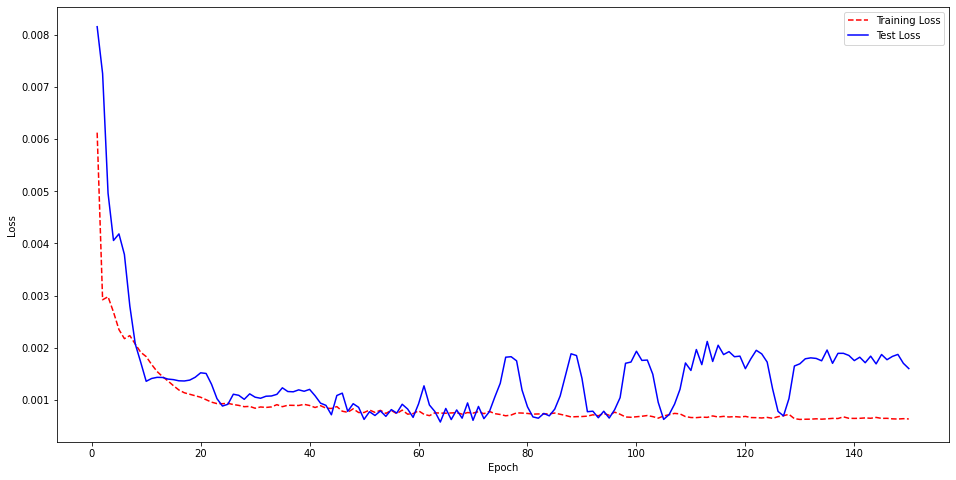

In [4]:

import matplotlib.pyplot as plt

training_loss = history.history["loss"]
test_loss = history.history["val_loss"]

epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
fig = plt.figure(figsize=(16, 8))
plt.plot(epoch_count, training_loss, "r--")
plt.plot(epoch_count, test_loss, "b-")
plt.legend(["Training Loss", "Test Loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
